## **Image segmentation U-Net**

An image is a collection or set of different pixels. We group together the pixels that have similar attributes using image segmentation. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level.In image segmetation each pixel is given a label.

## **Import** **Libraries** 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras.backend as K
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

## Getting Dataset from Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [03:21<00:00, 154MB/s]
100% 24.4G/24.4G [03:21<00:00, 130MB/s]


Let's unzip all the files

In [ ]:
!unzip /content/carvana-image-masking-challenge.zip

Archive:  /content/carvana-image-masking-challenge.zip
  inflating: 29bb3ece3180_11.jpg     
  inflating: metadata.csv.zip        
  inflating: sample_submission.csv.zip  
  inflating: test.zip                
  inflating: test_hq.zip             
  inflating: train.zip               
  inflating: train_hq.zip            
  inflating: train_masks.csv.zip     
  inflating: train_masks.zip         


In [ ]:
!unzip /content/train.zip

In [ ]:
!unzip/content/train_masks.zip


/bin/bash: unzip/content/train_masks.zip: No such file or directory


In [ ]:
!unzip /content/train_masks.zip

In [ ]:
print("Train set:  ", len(os.listdir("/content/train")))
print("Train masks:", len(os.listdir("/content/train_masks")))

Train set:   5088
Train masks: 5088


In [ ]:
car_ids = []
paths = []
for dirname, _, filenames in os.walk("/content/train"):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    paths.append(path)

    car_id = filename.split(".")[0]
    car_ids.append(car_id)

In [ ]:
d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

,car_path
id,
23c088f6ec27_14,/content/train/23c088f6ec27_14.jpg
4b74275babf7_15,/content/train/4b74275babf7_15.jpg
11f3dc041cfb_07,/content/train/11f3dc041cfb_07.jpg
66fea07e1152_12,/content/train/66fea07e1152_12.jpg
120c1dc7b116_10,/content/train/120c1dc7b116_10.jpg
...,...
be86e79f1225_05,/content/train/be86e79f1225_05.jpg
3b45f83ba3fa_12,/content/train/3b45f83ba3fa_12.jpg
3d7a1030deeb_04,/content/train/3d7a1030deeb_04.jpg


In [ ]:
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk("/content/train_masks"):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    mask_path.append(path)

    car_id = filename.split(".")[0]
    car_id = car_id.split("_mask")[0]
    car_ids.append(car_id)

In [ ]:
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

,mask_path
id,
c4f1840b2a65_10,/content/train_masks/c4f1840b2a65_10_mask.gif
bd8d5780ed04_09,/content/train_masks/bd8d5780ed04_09_mask.gif
fdc2c87853ce_02,/content/train_masks/fdc2c87853ce_02_mask.gif
e5fc2c1c4a8b_10,/content/train_masks/e5fc2c1c4a8b_10_mask.gif
d8e1c401ac3c_02,/content/train_masks/d8e1c401ac3c_02_mask.gif
...,...
b63a6f7952d4_16,/content/train_masks/b63a6f7952d4_16_mask.gif
6343156803f9_05,/content/train_masks/6343156803f9_05_mask.gif
795d2ee07ce2_06,/content/train_masks/795d2ee07ce2_06_mask.gif


In [ ]:
df["mask_path"] = mask_df["mask_path"]
df.head()

,car_path,mask_path
id,,
23c088f6ec27_14,/content/train/23c088f6ec27_14.jpg,/content/train_masks/23c088f6ec27_14_mask.gif
4b74275babf7_15,/content/train/4b74275babf7_15.jpg,/content/train_masks/4b74275babf7_15_mask.gif
11f3dc041cfb_07,/content/train/11f3dc041cfb_07.jpg,/content/train_masks/11f3dc041cfb_07_mask.gif
66fea07e1152_12,/content/train/66fea07e1152_12.jpg,/content/train_masks/66fea07e1152_12_mask.gif
120c1dc7b116_10,/content/train/120c1dc7b116_10.jpg,/content/train_masks/120c1dc7b116_10_mask.gif


Now we will perform a simple augmentation of flipping an image and then normalize the image pixel in between 0 and 1

In [ ]:
img_size = [256,256]
def data_augmentation(car_img, mask_img):
   if tf.random.uniform(())>0.5 :
     car_img = tf.image.flip_left_right(car_img)
     mask_img = tf.image.flip_left_right(mask_img)
   
   return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0

    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)

    return car_img, mask_img


In [ ]:
def create_dataset(df, train = False):
  if not train:
    ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
    ds = ds.map(preprocessing, tf.data.AUTOTUNE)

  else:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)
  return ds


Now we will split the dataset into train and test

In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)

train = create_dataset(train_df, train = True) #We are applying data augmentation to the training set so we put train = True
valid = create_dataset(valid_df) 

In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

Let's look the image and it's corresponding mask

In [ ]:
def display(display_list):
  plt.figure(figsize = (15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

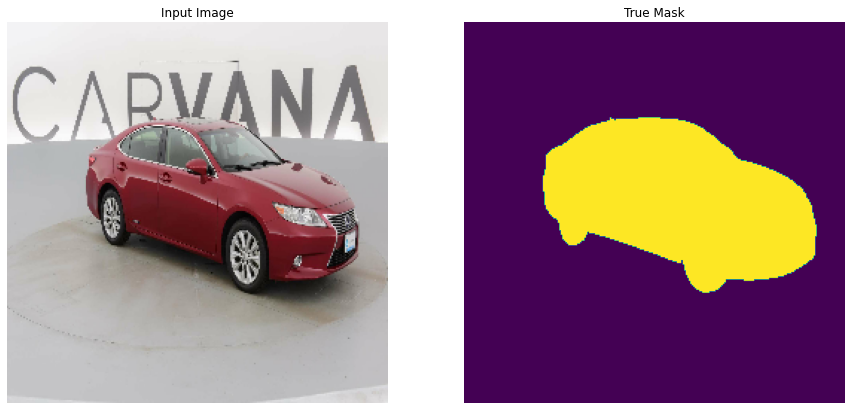

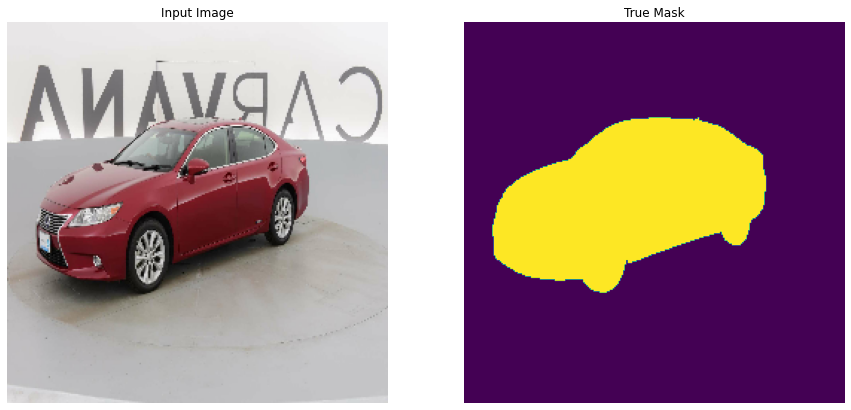

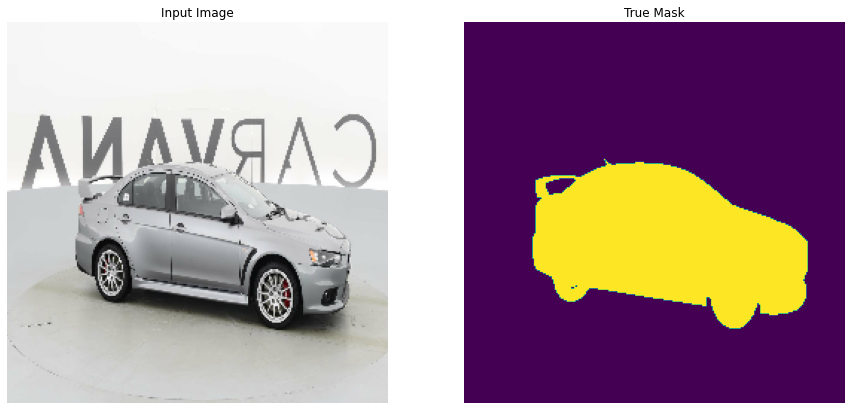

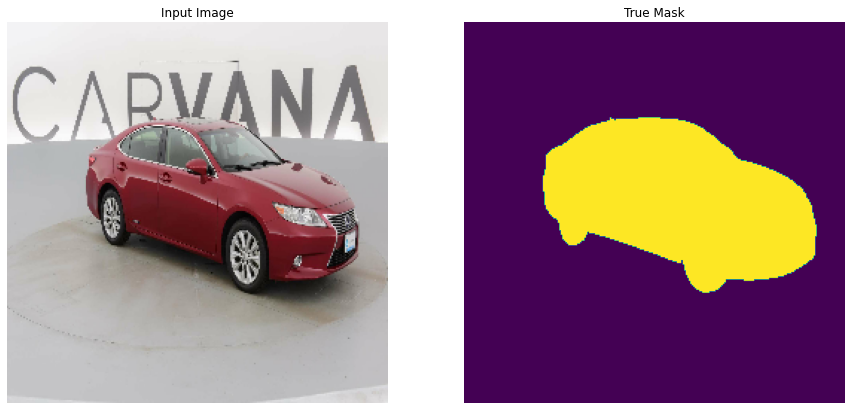

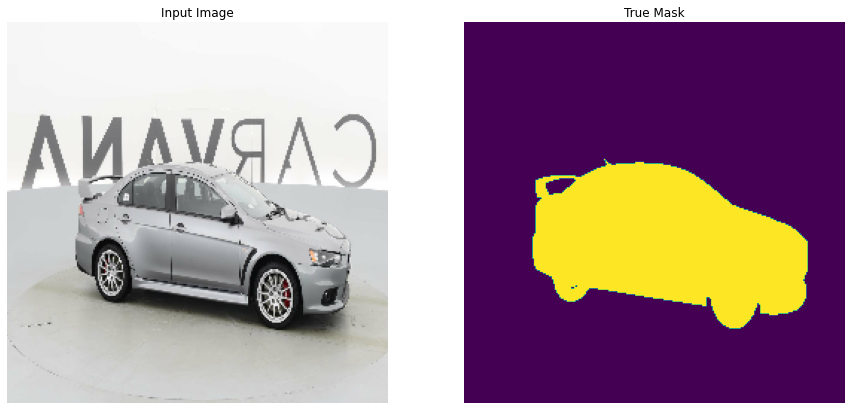

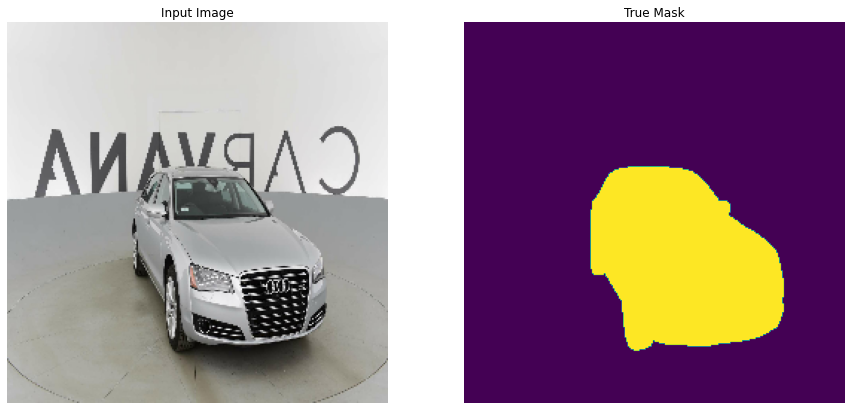

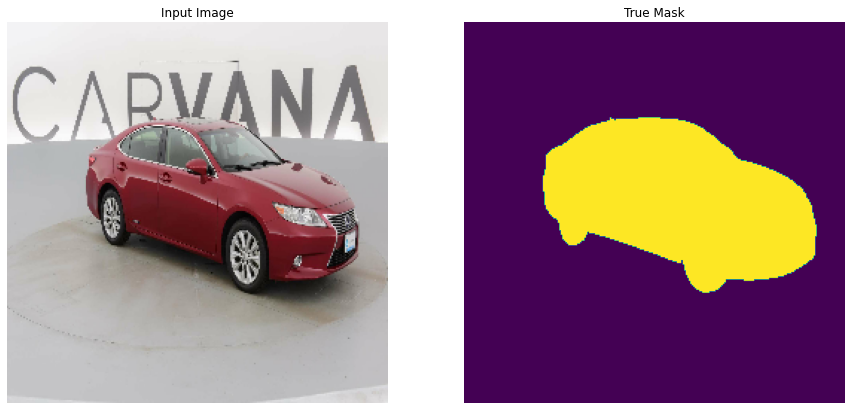

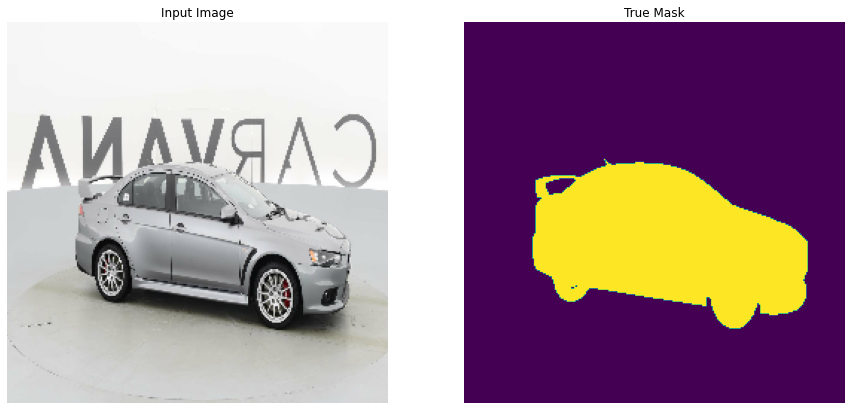

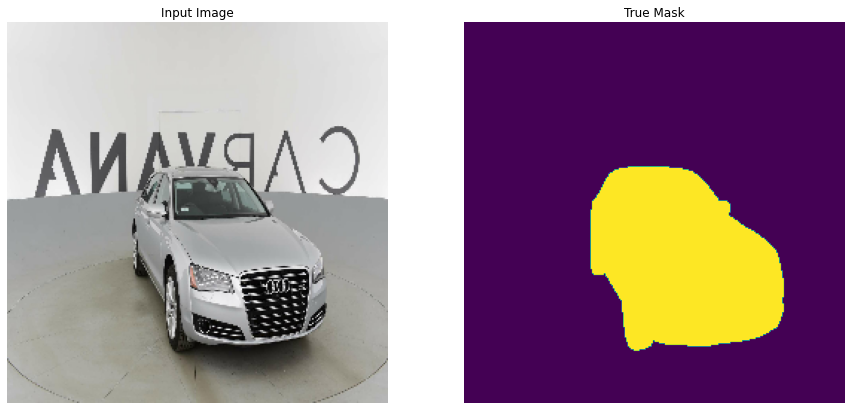

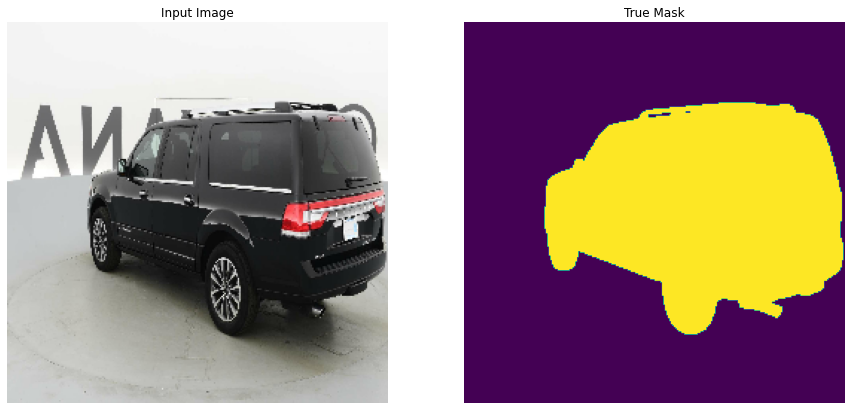

In [ ]:
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

# Model

We are going to use U-Net model. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.The encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications.

In [ ]:
base_model =tf.keras.applications.MobileNetV2(input_shape = [256,256,3], include_top = False)

#Use activations of these layers

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project']     # 4x4

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Train the Model

Now let's compile the model and see the model architecture

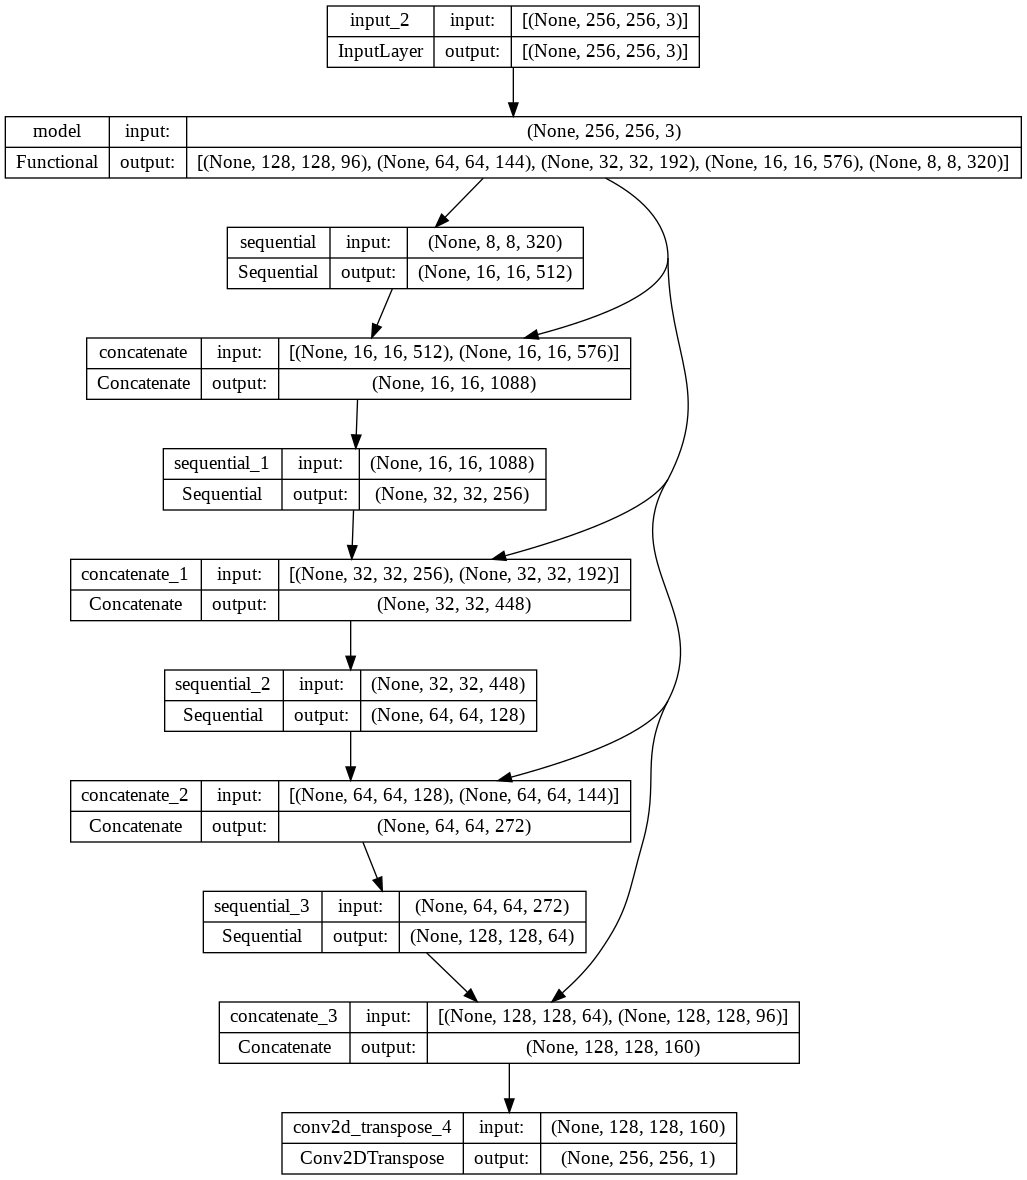

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

1/1 [==============================] - 1s 1s/step


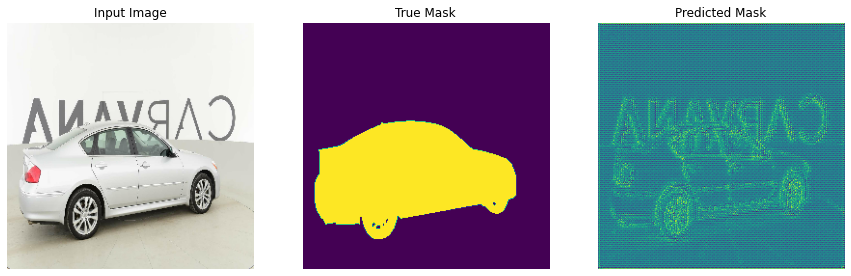

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

Epoch 1/15
119/119 [==============================] - 1471s 12s/step - loss: 0.0958 - dice_coef: 0.9042 - binary_accuracy: 0.9702 - val_loss: 0.0390 - val_dice_coef: 0.9610 - val_binary_accuracy: 0.9858
Epoch 2/15
119/119 [==============================] - 1427s 12s/step - loss: 0.0286 - dice_coef: 0.9714 - binary_accuracy: 0.9906 - val_loss: 0.0302 - val_dice_coef: 0.9698 - val_binary_accuracy: 0.9898


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 273ms/step


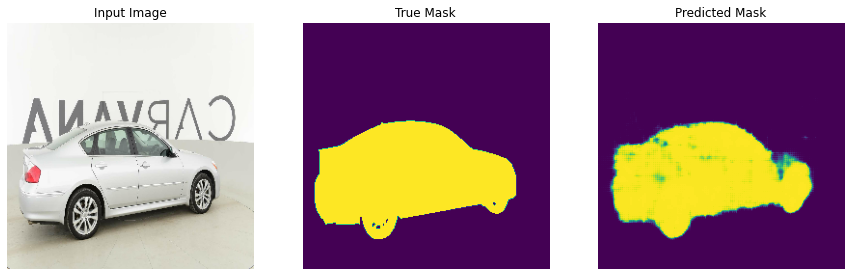

Epoch 3/15
119/119 [==============================] - 1336s 11s/step - loss: 0.0240 - dice_coef: 0.9759 - binary_accuracy: 0.9915 - val_loss: 0.0302 - val_dice_coef: 0.9698 - val_binary_accuracy: 0.9893
Epoch 4/15
119/119 [==============================] - 1388s 12s/step - loss: 0.0221 - dice_coef: 0.9778 - binary_accuracy: 0.9919 - val_loss: 0.0221 - val_dice_coef: 0.9779 - val_binary_accuracy: 0.9919
Epoch 5/15
1/1 [==============================] - 0s 328ms/step


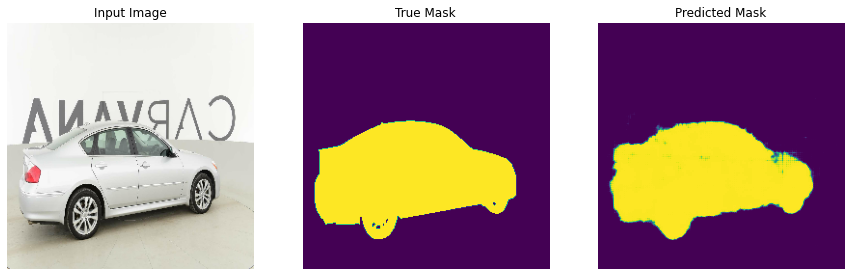

Epoch 6/15
119/119 [==============================] - 1440s 12s/step - loss: 0.0201 - dice_coef: 0.9799 - binary_accuracy: 0.9924 - val_loss: 0.0208 - val_dice_coef: 0.9792 - val_binary_accuracy: 0.9920
Epoch 7/15
119/119 [==============================] - 1440s 12s/step - loss: 0.0195 - dice_coef: 0.9805 - binary_accuracy: 0.9925 - val_loss: 0.0207 - val_dice_coef: 0.9793 - val_binary_accuracy: 0.9920
Epoch 8/15
1/1 [==============================] - 0s 210ms/step


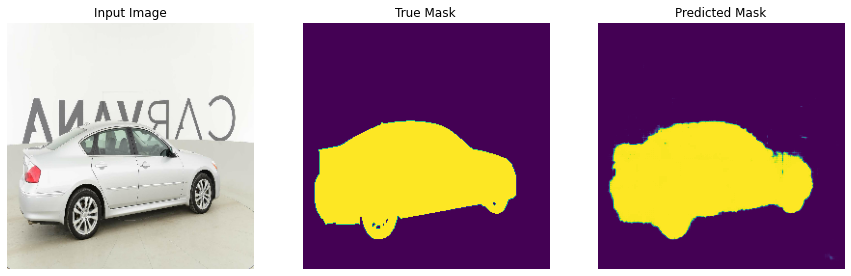

Epoch 9/15
119/119 [==============================] - 1416s 12s/step - loss: 0.0186 - dice_coef: 0.9814 - binary_accuracy: 0.9927 - val_loss: 0.0191 - val_dice_coef: 0.9809 - val_binary_accuracy: 0.9924
Epoch 10/15
119/119 [==============================] - 1468s 12s/step - loss: 0.0183 - dice_coef: 0.9817 - binary_accuracy: 0.9928 - val_loss: 0.0194 - val_dice_coef: 0.9806 - val_binary_accuracy: 0.9923
Epoch 11/15
 10/119 [=>............................] - ETA: 17:34 - loss: 0.0180 - dice_coef: 0.9818 - binary_accuracy: 0.9930

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
